# PATH PLANNING CLEAN

In [1]:
# NEEDED CONSTANTS
reduction_coeff = 25
ROTATION_COST = 1


# IMPORTS :
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tdmclient import aw, ClientAsync
from matplotlib import colors
import math
import time

%matplotlib inline

---
### Path Planning


The path search is transformed into a graph search. A problem encountered is the computational time needed for a grid the size of the image. To reduce this duration a size reduction coefficient is used to downsize the original grid. The value of this coefficient is chosen to have the best trade-off between computational time and precision.

| `reduction_coeff` | Computation time |
|----------|----------|
| 10 | 9.599 |
| 15 | 2.298 |
| 20 | 0.513 |
| 25 | 0.193 |
| 30 | 0.099 |

The solution with the best trade-off is a reduction factor of 25, allowing an average computational time of 0.193s while keeping acceptable precision.

In [2]:
def  create_downsized_grid(global_obstacle):
    """ 
    Creation of the downsized grid occupation_grid with a scale of reduction_coeff
    
    param : 
        - global_obstacle : grid containing the obstacle positions with original size
    return : 
        - occupancy_grid: Downsized grid with averaged obstacle positions
    """

    # Invert the data to have a value of 0 for free cells and 1 for occupied cells.
    # global_obstacle = np.logical_not( global_obstacle )  
    max_val_x_init = global_obstacle.shape[0]
    max_val_y_init = global_obstacle.shape[1]

    # The size of the new grid is calculated from the size of the original grid global_obstacle
    max_val_x = int(max_val_x_init / reduction_coeff)
    max_val_y = int(max_val_y_init / reduction_coeff)

    # Creation of the downsized grid with
    occupancy_grid = np.zeros((max_val_x, max_val_y), dtype=int)

    # Inspection of squares (of size reduction_coeff*reduction_coeff) in the original grid
    for i in range (max_val_x):
        for j in range (max_val_y):
            sum_pixels = 0

            for k in range (reduction_coeff):

                # Verification that the indexs indice_x and indice_y are in the grid range
                indice_x = int(i * reduction_coeff - reduction_coeff/2 + k)
                if (indice_x < 0):
                    indice_x = 0
                elif (indice_x > (max_val_x_init - 1)):
                    indice_x = max_val_x_init -1

                indice_y = int(j * reduction_coeff - reduction_coeff/2 + k)
                if (indice_y < 0):

                    indice_y = 0
                elif (indice_y > (max_val_y_init - 1)):
                    indice_y = max_val_y_init -1

                # The sum of all values present in the inspected square is stored in sum_pixels
                sum_pixels = sum_pixels + global_obstacle[indice_x][indice_y]


            # If an obstacle is found in the square, a 1 is placed in the corresponding position in the new grid
            if sum_pixels == 0:
                occupancy_grid[i][j] = 0
            else:
                occupancy_grid[i][j] = 1

    return occupancy_grid

In [3]:
def create_empty_plot(max_val_x, max_val_y):
    """
    Creation of a figure to plot a matrix of max size max_val 
    
    param : 
        - max_val_x : maximum dimension of the matrix on x axis
        - max_val_y : maximum dimension of the matrix on y axis
    return:
        -  fig : general figure
        -  ax : axis information
    """
    
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val_y+1, 5)
    minor_ticks = np.arange(0, max_val_y+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    
    # Definition of axis limits with the information of the matrix size
    ax.set_ylim([max_val_x,-1])
    ax.set_xlim([-1,max_val_y])
    ax.grid(True)
    
    return fig, ax

### A* implementation

The path planning for the Thymio is made using a hybrid A* algorithm. This ensures an optimised search by using the distance to goal to choose the nodes to explore. The formula used is the following : 

$$ f(n) = g(n) + h(n) $$

Here f(n) is the function we try to optimise, with g(n) being the motion cost and h(n) the heuristic function. The motion cost has here been tailored to the Thymio's mechanism, as it takes into account on one side the cost of forward motion with `deltacost` and on the other side the rotational cost with `rotational_cost`. Adding the rotational cost is key to avoid repetitive direction changes.

In [4]:
def _get_movements_8n():
    """
    Get all possible 8-connectivity movements : up, down, left, right and the 4 diagonals.
    
    return : 
        - list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [5]:
def reconstruct_path(cameFrom, current):
    """
    Reconstructs the path from start node to the current node
    
    param :
        - cameFrom: map (dict) containing for each node the node immediately 
                     preceding it on the cheapest path currently known.
        - param current : current node (x, y)
        
    return : 
        - total_path : list of nodes from start to current node
    """
    
    # The first item is the current node
    total_path = [current]
    
    while current in cameFrom.keys():
        # Add the previous node to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current = cameFrom[current]
    return total_path

In [6]:
def A_Star(start, goal, h, coords, occupancy_grid):
    """
    Implementation of the A* algorithm, finding the cheapest path from start to goal 
    
    param :
        - start : start node (x, y)
        - goal: goal node (x, y)
        - h : heuristic function (distance to goal)
        - coords : coordinates in the grid
        - occupancy_grid: downsized grid map with obstacle information
    
    return : 
        - a tuple containing the path distance and the path information in an array of indexs
    """
    
    # Size of the downscaled grid
    max_val_x = occupancy_grid.shape[0]
    max_val_y = occupancy_grid.shape[1]
    
    # Check if the start and goal are within the limits of the grid's size
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val_y, "start or end goal not contained in the map"
    
    # Check if start and goal nodes are situated on an obstacle
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # Information on the possible movements
    movements = _get_movements_8n()
    
    # --------------------------------------------------------------#
    #                  A* ALGORITHM IMPLEMENTATION                  #
    # --------------------------------------------------------------#
    
    # The set of visited nodes, which are the starting points for neighbor exploration
    # The start node is the only one known yet.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # map containing for each node the node immediately preceding it on the cheapest path currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]
    

    # While there are still cells to explore
    while openSet != []:
        
        # The node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        # If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        # For each neighbor of the current node 
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # If the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # If the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
            
            # Computation of the rotational cost by comparing the previous position, the current one and the next one
            if(not (current == start)):
                vector_prev = ([current[0] - (cameFrom[current])[0], current[1] - (cameFrom[current])[1]]) 
                vector_next = ([neighbor[0] - current[0], neighbor[1] - current[1]]) 
                angle = np.arccos(np.dot(vector_prev, vector_next) / (np.linalg.norm(vector_prev) * np.linalg.norm(vector_next)))
                rotation_cost = angle * ROTATION_COST
            else:
                rotation_cost = 0
                
            # The movement cost to the neighbor is the linear movement with deltacost and the rotation with rotational_cost
            # Tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost + rotation_cost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
            
            # If the path to the neighbor is better than any previous one, keep it
            if tentative_gScore < gScore[neighbor]:
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

The path_final matrix is structured such that the y-coordinates are on the first row and the x-coordinates on the second. Consequently, an inversion of these two rows is required prior to executing the robot's movement.

Moreover, the downsizing operation of the original grid introduces inaccuracies regarding the initial and final position of the robot. To mitigate this limitation, the exact coordinates of these two specific positions are preferred over the values returned by the A* algorithm when constructing the movement array.

In [7]:
def path_planning(robot_vector, goal_center, global_obstacle):
    """
    This function calls the other path planning functions to compute the cheapest path
    
    param :
        - robot_vector : current position of the Thymio robot  
        - goal_center : center position of the goal
        - global_obstacle : original grid with obstacle information
    
    return :
        - path_final : list of coordinates forming the cheapest path
    """
    
    # Generate the downsized obstacle grid
    occupancy_grid = create_downsized_grid(global_obstacle)
    
    # Size of the downscaled grid
    max_val_x = occupancy_grid.shape[0]
    max_val_y = occupancy_grid.shape[1]
    
    # Define the start and end goal while changing axis to use matrix coordinates
    start = (int(robot_vector[1]/reduction_coeff), int(robot_vector[0]/reduction_coeff))
    goal = (int(goal_center[1]/reduction_coeff), int(goal_center[0]/reduction_coeff))

    # List of all coordinates in the grid
    w,z = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
    pos = np.empty(w.shape + (2,))
    pos[:, :, 0] = w; pos[:, :, 1] = z
    pos = np.reshape(pos, (w.shape[0]*w.shape[1], 2))
    coords = list([(int(w[0]), int(w[1])) for w in pos])
    
    # Define the heuristic, here = distance to goal ignoring obstacles
    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))

    # Run the A* algorithm    
    path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid)
    
    # Change axis to plot with same coordinates as the grid
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

    # Multiply the path coordinates by reduction_coeff to go back to the original grid scale
    path_final = path * reduction_coeff
    
    # Change axis to go back to the original coordinates
    path_final[[0,1]] = path_final[[1,0]] 
    
    # Replace the first and last node of the path to fit the true coordinates of the start and goal position
    path_final[0][0] = robot_vector[0]
    path_final[1][0] = robot_vector[1]
    path_final[0][-1] = goal_center[0]
    path_final[1][-1] = goal_center[1]
    
    # Displaying the map and the path information
    cmap = colors.ListedColormap(['white', 'red'])
    fig_astar, ax_astar = create_empty_plot(max_val_x, max_val_y)
    ax_astar.imshow(occupancy_grid, cmap=cmap)
    # Plot the best path found and the list of visited nodes
    ax_astar.scatter(visitedNodes[1], visitedNodes[0], marker="o", color = 'orange');
    ax_astar.plot(path[1], path[0], marker="o", color = 'blue');
    ax_astar.scatter(start[1], start[0], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[1], goal[0], marker="o", color = 'purple', s=200);
    
    return path_final


# TEST CELLS

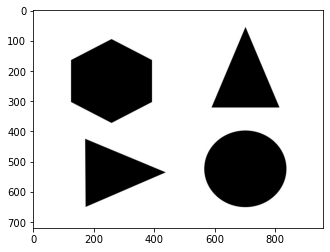

In [8]:
# Data initialisation, currently from a test file
image_path = 'C:/Users/adrie/Downloads/thymio_test2.jpg'

# Ouvrir l'image
img = Image.open(image_path)

# Afficher l'image
plt.imshow(img, cmap='gray')  # Utilisez 'gray' pour les images en niveaux de gris
plt.axis('on')  # Masquer les axes
plt.show()
    
# Convertir l'image en niveaux de gris si elle est en couleur
img = img.convert('L')
    
# Obtenir les données des pixels sous forme de tableau numpy
pixel_data = np.array(img)
    
# Convertir les valeurs des pixels en 0 pour blanc et 1 pour noir
binary_matrix = (pixel_data < 10).astype(int)

robot_vector = ([0, 0, 0])
goal_center = ([900,400])
#goal center

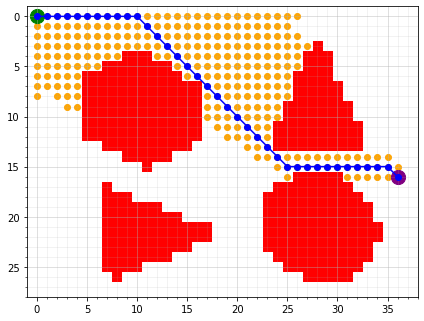

In [9]:
path_final = path_planning(robot_vector, goal_center, binary_matrix)